In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.math as tm
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score

In [2]:
def convert2_zero_one(x):
    
    t = [tf.math.sigmoid(i) for i in x]    
    return t

def cont_bern_log_norm(lam, l_lim=0.49, u_lim=0.51):
    '''
    computes the log normalizing constant of a continuous Bernoulli distribution in a numerically stable way.
    returns the log normalizing constant for lam in (0, l_lim) U (u_lim, 1) and a Taylor approximation in
    [l_lim, u_lim].
    cut_y below might appear useless, but it is important to not evaluate log_norm near 0.5 as tf.where evaluates
    both options, regardless of the value of the condition.
    '''
    
    cut_lam = tf.where(tm.logical_or(tm.less(lam, l_lim), tm.greater(lam, u_lim)), lam, l_lim * tf.ones_like(lam))
    log_norm = tm.log(tm.abs(2.0 * tm.atanh(1 - 2.0 * cut_lam))) - tm.log(tm.abs(1 - 2.0 * cut_lam))
    taylor = tm.log(2.0) + 4.0 / 3.0 * tm.pow(lam - 0.5, 2) + 104.0 / 45.0 * tm.pow(lam - 0.5, 4)
    return tf.where(tm.logical_or(tm.less(lam, l_lim), tm.greater(lam, u_lim)), log_norm, taylor)

In [3]:
class StochasticMLP(Model):
    
    def __init__(self, hidden_layer_sizes=[100], n_outputs=10, lr = 0.01):
        super(StochasticMLP, self).__init__()
        self.hidden_layer_sizes = hidden_layer_sizes
        self.fc_layers = [Dense(layer_size) for layer_size in hidden_layer_sizes]
        self.output_layer = Dense(n_outputs)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
        
    def call(self, x):
        
        network = []
        
        for i, layer in enumerate(self.fc_layers):
            
            logits = layer(x)
            x = tfp.distributions.Bernoulli(logits=logits).sample()
            network.append(x)

        final_logits = self.output_layer(x) # initial the weight of output layer
            
        return network
    
    def target_log_prob(self, x, h, y, is_hmc_kernel = False, is_loss = False):
        
        # get current state
        if is_hmc_kernel:
            h_current = tf.split(h, self.hidden_layer_sizes, axis = 1)
        else:    
            h_current = [tf.cast(h_i, dtype=tf.float32) for h_i in h]
        h_current = convert2_zero_one(h_current)
        h_previous = [x] + h_current[:-1]
    
        nlog_prob = 0. # negative log probability
        
        if not is_loss:
            for i, (cv, pv, layer) in enumerate(zip(h_current, h_previous, self.fc_layers)):
            
                logits = layer(pv)
                ce = tf.nn.sigmoid_cross_entropy_with_logits(labels = cv, logits = logits)
                ce += cont_bern_log_norm(tf.nn.sigmoid(logits))
            
                nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob
    
    def generate_hmc_kernel(self, x, y, step_size = pow(1000, -1/4)):
        
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn = lambda v: self.target_log_prob(x, v, y, is_hmc_kernel = True),
            num_leapfrog_steps = 2,
            step_size = step_size),
            num_adaptation_steps=int(100 * 0.8))
        
        return adaptive_hmc
    
    # new proposing-state method with HamiltonianMonteCarlo
    def propose_new_state_hamiltonian(self, x, h, y, hmc_kernel, is_update_kernel = True):
    
        h_current = h
        h_current = [tf.cast(h_i, dtype=tf.float32) for h_i in h_current]
        h_current = tf.concat(h_current, axis = 1)

        # run the chain (with burn-in)
        num_burnin_steps = 0
        num_results = 1

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = h_current, # may need to be reshaped
            kernel = hmc_kernel,
            trace_fn = None,
            return_final_kernel_results = True)
    
        # Generate new states of chains
        h_state = samples[0][0]
        h_new = tf.split(h_state, self.hidden_layer_sizes, axis = 1) 
        
        # Update the kernel if necesssary
        if is_update_kernel:
            new_step_size = samples[2].new_step_size.numpy()
            ker_new = self.generate_hmc_kernel(x, y, new_step_size)
            return(h_new, ker_new)
        else:
            return h_new
    
    def update_weights(self, x, h, y):
        
        with tf.GradientTape() as tape:
            loss = -1 * tf.reduce_mean(self.target_log_prob(x, h, y))
        
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    
    def get_predictions(self, x):

        logits = 0.0
        for layer in self.fc_layers:
            logits = layer(x)
            x = tm.sigmoid(logits)
        
        logits = self.output_layer(x)
        probs = tm.sigmoid(logits)
        labels = tf.cast(tm.greater(probs, 0.5), tf.int32)

        return probs.numpy(), labels

In [4]:
def hmc(data, epochs):
    '''
    HMC training
    '''
    
    print("Start HMC")
    model = StochasticMLP(hidden_layer_sizes = [size], n_outputs=1, lr = 0.01)
    network = [model.call(images) for images, labels in data]
    kernels = [model.generate_hmc_kernel(images, labels) for images, labels in data]
    
    print("Start HMC Burning")
    burnin = 1000
    tlp = []
    for i in range(burnin):
        
        if(i % 100 == 0): print("Step %d" % i)
        #network, kernels = zip(*[model.propose_new_state_hamiltonian(x, net, y, ker) 
        #           for (x, y), net, ker in zip(data, network, kernels)])
        res = []
        loss = 0.0
        for (x, y), net, ker in zip(train_ds, network, kernels):
            res.append(model.propose_new_state_hamiltonian(x, net, y, ker))
            loss += -1 * tf.reduce_sum(model.target_log_prob(x, net, y))
    
        network, kernels = zip(*res)
        tlp.append(loss / 4)
        
    
    print("Start HMC Training")
    loss_ls = []
    label_acc_ls = []
    prob_acc_ls = []
    start_time = time.time()
    
    probs_0 = []
    probs_1 = []
    probs_2 = []
    probs_3 = []
    for epoch in range(epochs):
    
        loss = 0.0
        acc = 0.0
        for bs, (x, y) in enumerate(data):
        
            # only one mini-batch
            model.update_weights(x, network[bs], y)
            res = [model.propose_new_state_hamiltonian(x, net, y, ker, is_update_kernel = False) \
                       for (x, y), net, ker in zip(data, network, kernels)]
            network = res
            loss += -1 * tf.reduce_mean(model.target_log_prob(x, network[bs], y, is_loss = True))
    
        probs, preds = zip(*[model.get_predictions(images) for images, labels in data])
        probs = np.concatenate(probs)
        preds = np.concatenate(preds)
        
        label_acc = accuracy_score(np.concatenate(preds), y_train)
        prob_acc = sum([prob * y + (1 - prob) * (1 - y) for prob, y in zip(probs, y_train)]) / len(y_train)
        
        probs_0.append(probs[0])
        probs_1.append(probs[1])
        probs_2.append(probs[2])
        probs_3.append(probs[3])
        
        loss_ls.append(loss / 4)
        label_acc_ls.append(label_acc)
        prob_acc_ls.append(prob_acc)
    
        print("Epoch %d/%d: - %.4fs/step - loss: %.4f - label accuracy: %.4f - prob accuracy: %.4f" 
            % (epoch + 1, epochs, (time.time() - start_time) / (epoch + 1), loss_ls[epoch], label_acc, prob_acc))

    train_time = time.time() - start_time
    return tlp, train_time, {"prob_acc": prob_acc_ls, "label_acc": label_acc_ls, "loss": loss_ls}, (probs_0, probs_1, probs_2, probs_3)

In [5]:
x_train = np.array([[0, 0],
           [0, 1],
           [1, 0],
           [1, 1]])
y_train = np.array([[0],
           [1],
           [1],
           [0]])
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(4)

2021-11-29 15:06:04.455286: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
model_size = [32]
for size in model_size:
    
    epochs = 1000
    tlp_burnin_hmc, time_hmc, history_hmc, (probs_0, probs_1, probs_2, probs_3) = hmc(train_ds, epochs)

Start HMC
Start HMC Burning
Step 0
Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Start HMC Training
Epoch 1/1000: - 0.0398s/step - loss: 0.1451 - label accuracy: 0.5000 - prob accuracy: 0.5000
Epoch 2/1000: - 0.0379s/step - loss: 0.1402 - label accuracy: 0.5000 - prob accuracy: 0.5000
Epoch 3/1000: - 0.0369s/step - loss: 0.1150 - label accuracy: 0.5000 - prob accuracy: 0.5000
Epoch 4/1000: - 0.0367s/step - loss: 0.1141 - label accuracy: 0.5000 - prob accuracy: 0.5000
Epoch 5/1000: - 0.0366s/step - loss: 0.0983 - label accuracy: 0.5000 - prob accuracy: 0.5000
Epoch 6/1000: - 0.0370s/step - loss: 0.1038 - label accuracy: 0.5000 - prob accuracy: 0.5000
Epoch 7/1000: - 0.0377s/step - loss: 0.0963 - label accuracy: 0.5000 - prob accuracy: 0.5000
Epoch 8/1000: - 0.0382s/step - loss: 0.0939 - label accuracy: 0.5000 - prob accuracy: 0.5000
Epoch 9/1000: - 0.0384s/step - loss: 0.0931 - label accuracy: 0.5000 - prob accuracy: 0.5000
Epoch 10/1000: - 0.0382s/ste

Epoch 90/1000: - 0.0383s/step - loss: 0.0266 - label accuracy: 0.5000 - prob accuracy: 0.5075
Epoch 91/1000: - 0.0383s/step - loss: 0.0450 - label accuracy: 0.5000 - prob accuracy: 0.5077
Epoch 92/1000: - 0.0383s/step - loss: 0.0422 - label accuracy: 0.5000 - prob accuracy: 0.5079
Epoch 93/1000: - 0.0383s/step - loss: 0.0304 - label accuracy: 0.5000 - prob accuracy: 0.5080
Epoch 94/1000: - 0.0382s/step - loss: 0.0350 - label accuracy: 0.5000 - prob accuracy: 0.5081
Epoch 95/1000: - 0.0382s/step - loss: 0.0365 - label accuracy: 0.5000 - prob accuracy: 0.5082
Epoch 96/1000: - 0.0382s/step - loss: 0.0370 - label accuracy: 0.5000 - prob accuracy: 0.5084
Epoch 97/1000: - 0.0383s/step - loss: 0.0479 - label accuracy: 0.5000 - prob accuracy: 0.5085
Epoch 98/1000: - 0.0384s/step - loss: 0.0439 - label accuracy: 0.5000 - prob accuracy: 0.5087
Epoch 99/1000: - 0.0384s/step - loss: 0.0302 - label accuracy: 0.5000 - prob accuracy: 0.5088
Epoch 100/1000: - 0.0384s/step - loss: 0.0221 - label accura

Epoch 178/1000: - 0.0383s/step - loss: 0.0205 - label accuracy: 0.5000 - prob accuracy: 0.5233
Epoch 179/1000: - 0.0383s/step - loss: 0.0187 - label accuracy: 0.5000 - prob accuracy: 0.5235
Epoch 180/1000: - 0.0383s/step - loss: 0.0114 - label accuracy: 0.5000 - prob accuracy: 0.5235
Epoch 181/1000: - 0.0383s/step - loss: 0.0142 - label accuracy: 0.5000 - prob accuracy: 0.5235
Epoch 182/1000: - 0.0383s/step - loss: 0.0135 - label accuracy: 0.5000 - prob accuracy: 0.5235
Epoch 183/1000: - 0.0383s/step - loss: 0.0131 - label accuracy: 0.5000 - prob accuracy: 0.5235
Epoch 184/1000: - 0.0383s/step - loss: 0.0143 - label accuracy: 0.5000 - prob accuracy: 0.5235
Epoch 185/1000: - 0.0383s/step - loss: 0.0168 - label accuracy: 0.5000 - prob accuracy: 0.5235
Epoch 186/1000: - 0.0383s/step - loss: 0.0173 - label accuracy: 0.5000 - prob accuracy: 0.5236
Epoch 187/1000: - 0.0383s/step - loss: 0.0175 - label accuracy: 0.5000 - prob accuracy: 0.5238
Epoch 188/1000: - 0.0383s/step - loss: 0.0171 - la

Epoch 266/1000: - 0.0382s/step - loss: 0.0074 - label accuracy: 0.5000 - prob accuracy: 0.5433
Epoch 267/1000: - 0.0382s/step - loss: 0.0122 - label accuracy: 0.5000 - prob accuracy: 0.5438
Epoch 268/1000: - 0.0382s/step - loss: 0.0128 - label accuracy: 0.5000 - prob accuracy: 0.5444
Epoch 269/1000: - 0.0382s/step - loss: 0.0176 - label accuracy: 0.7500 - prob accuracy: 0.5449
Epoch 270/1000: - 0.0382s/step - loss: 0.0172 - label accuracy: 0.7500 - prob accuracy: 0.5454
Epoch 271/1000: - 0.0381s/step - loss: 0.0182 - label accuracy: 0.7500 - prob accuracy: 0.5460
Epoch 272/1000: - 0.0381s/step - loss: 0.0176 - label accuracy: 0.7500 - prob accuracy: 0.5467
Epoch 273/1000: - 0.0382s/step - loss: 0.0170 - label accuracy: 0.7500 - prob accuracy: 0.5473
Epoch 274/1000: - 0.0381s/step - loss: 0.0164 - label accuracy: 0.7500 - prob accuracy: 0.5480
Epoch 275/1000: - 0.0381s/step - loss: 0.0159 - label accuracy: 0.7500 - prob accuracy: 0.5486
Epoch 276/1000: - 0.0381s/step - loss: 0.0124 - la

Epoch 356/1000: - 0.0379s/step - loss: 0.0075 - label accuracy: 0.5000 - prob accuracy: 0.5336
Epoch 357/1000: - 0.0379s/step - loss: 0.0074 - label accuracy: 0.5000 - prob accuracy: 0.5334
Epoch 358/1000: - 0.0379s/step - loss: 0.0051 - label accuracy: 0.5000 - prob accuracy: 0.5331
Epoch 359/1000: - 0.0379s/step - loss: 0.0163 - label accuracy: 0.5000 - prob accuracy: 0.5330
Epoch 360/1000: - 0.0379s/step - loss: 0.0204 - label accuracy: 0.5000 - prob accuracy: 0.5332
Epoch 361/1000: - 0.0379s/step - loss: 0.0201 - label accuracy: 0.5000 - prob accuracy: 0.5335
Epoch 362/1000: - 0.0379s/step - loss: 0.0165 - label accuracy: 0.5000 - prob accuracy: 0.5340
Epoch 363/1000: - 0.0379s/step - loss: 0.0110 - label accuracy: 0.5000 - prob accuracy: 0.5348
Epoch 364/1000: - 0.0379s/step - loss: 0.0107 - label accuracy: 0.5000 - prob accuracy: 0.5357
Epoch 365/1000: - 0.0379s/step - loss: 0.0104 - label accuracy: 0.5000 - prob accuracy: 0.5366
Epoch 366/1000: - 0.0379s/step - loss: 0.0101 - la

Epoch 446/1000: - 0.0378s/step - loss: 0.0123 - label accuracy: 0.7500 - prob accuracy: 0.5805
Epoch 447/1000: - 0.0378s/step - loss: 0.0121 - label accuracy: 0.7500 - prob accuracy: 0.5806
Epoch 448/1000: - 0.0378s/step - loss: 0.0118 - label accuracy: 0.7500 - prob accuracy: 0.5806
Epoch 449/1000: - 0.0378s/step - loss: 0.0111 - label accuracy: 0.7500 - prob accuracy: 0.5805
Epoch 450/1000: - 0.0378s/step - loss: 0.0109 - label accuracy: 0.7500 - prob accuracy: 0.5805
Epoch 451/1000: - 0.0377s/step - loss: 0.0108 - label accuracy: 0.7500 - prob accuracy: 0.5804
Epoch 452/1000: - 0.0377s/step - loss: 0.0106 - label accuracy: 0.7500 - prob accuracy: 0.5803
Epoch 453/1000: - 0.0378s/step - loss: 0.0105 - label accuracy: 0.7500 - prob accuracy: 0.5802
Epoch 454/1000: - 0.0378s/step - loss: 0.0188 - label accuracy: 0.7500 - prob accuracy: 0.5801
Epoch 455/1000: - 0.0377s/step - loss: 0.0102 - label accuracy: 0.7500 - prob accuracy: 0.5802
Epoch 456/1000: - 0.0377s/step - loss: 0.0106 - la

Epoch 536/1000: - 0.0377s/step - loss: 0.0068 - label accuracy: 0.7500 - prob accuracy: 0.6041
Epoch 537/1000: - 0.0377s/step - loss: 0.0067 - label accuracy: 0.7500 - prob accuracy: 0.6043
Epoch 538/1000: - 0.0377s/step - loss: 0.0066 - label accuracy: 0.7500 - prob accuracy: 0.6045
Epoch 539/1000: - 0.0377s/step - loss: 0.0065 - label accuracy: 0.7500 - prob accuracy: 0.6047
Epoch 540/1000: - 0.0377s/step - loss: 0.0064 - label accuracy: 0.7500 - prob accuracy: 0.6050
Epoch 541/1000: - 0.0377s/step - loss: 0.0061 - label accuracy: 0.7500 - prob accuracy: 0.6052
Epoch 542/1000: - 0.0377s/step - loss: 0.0060 - label accuracy: 0.7500 - prob accuracy: 0.6055
Epoch 543/1000: - 0.0377s/step - loss: 0.0059 - label accuracy: 0.7500 - prob accuracy: 0.6058
Epoch 544/1000: - 0.0377s/step - loss: 0.0062 - label accuracy: 0.7500 - prob accuracy: 0.6061
Epoch 545/1000: - 0.0377s/step - loss: 0.0061 - label accuracy: 0.7500 - prob accuracy: 0.6064
Epoch 546/1000: - 0.0377s/step - loss: 0.0060 - la

Epoch 626/1000: - 0.0377s/step - loss: 0.0049 - label accuracy: 0.7500 - prob accuracy: 0.6121
Epoch 627/1000: - 0.0377s/step - loss: 0.0047 - label accuracy: 0.7500 - prob accuracy: 0.6129
Epoch 628/1000: - 0.0377s/step - loss: 0.0046 - label accuracy: 0.7500 - prob accuracy: 0.6138
Epoch 629/1000: - 0.0377s/step - loss: 0.0051 - label accuracy: 0.7500 - prob accuracy: 0.6147
Epoch 630/1000: - 0.0377s/step - loss: 0.0049 - label accuracy: 0.7500 - prob accuracy: 0.6157
Epoch 631/1000: - 0.0377s/step - loss: 0.0048 - label accuracy: 0.7500 - prob accuracy: 0.6168
Epoch 632/1000: - 0.0377s/step - loss: 0.0047 - label accuracy: 0.7500 - prob accuracy: 0.6178
Epoch 633/1000: - 0.0377s/step - loss: 0.0038 - label accuracy: 0.7500 - prob accuracy: 0.6188
Epoch 634/1000: - 0.0377s/step - loss: 0.0044 - label accuracy: 0.7500 - prob accuracy: 0.6198
Epoch 635/1000: - 0.0377s/step - loss: 0.0043 - label accuracy: 0.7500 - prob accuracy: 0.6209
Epoch 636/1000: - 0.0377s/step - loss: 0.0042 - la

Epoch 716/1000: - 0.0376s/step - loss: 0.0061 - label accuracy: 0.7500 - prob accuracy: 0.6345
Epoch 717/1000: - 0.0376s/step - loss: 0.0051 - label accuracy: 0.7500 - prob accuracy: 0.6340
Epoch 718/1000: - 0.0376s/step - loss: 0.0043 - label accuracy: 0.7500 - prob accuracy: 0.6334
Epoch 719/1000: - 0.0376s/step - loss: 0.0042 - label accuracy: 0.7500 - prob accuracy: 0.6329
Epoch 720/1000: - 0.0376s/step - loss: 0.0041 - label accuracy: 0.7500 - prob accuracy: 0.6324
Epoch 721/1000: - 0.0376s/step - loss: 0.0041 - label accuracy: 0.7500 - prob accuracy: 0.6319
Epoch 722/1000: - 0.0376s/step - loss: 0.0046 - label accuracy: 0.7500 - prob accuracy: 0.6314
Epoch 723/1000: - 0.0376s/step - loss: 0.0045 - label accuracy: 0.7500 - prob accuracy: 0.6309
Epoch 724/1000: - 0.0376s/step - loss: 0.0045 - label accuracy: 0.7500 - prob accuracy: 0.6304
Epoch 725/1000: - 0.0376s/step - loss: 0.0044 - label accuracy: 0.7500 - prob accuracy: 0.6300
Epoch 726/1000: - 0.0376s/step - loss: 0.0044 - la

Epoch 806/1000: - 0.0376s/step - loss: 0.0033 - label accuracy: 0.7500 - prob accuracy: 0.6546
Epoch 807/1000: - 0.0376s/step - loss: 0.0021 - label accuracy: 0.7500 - prob accuracy: 0.6544
Epoch 808/1000: - 0.0376s/step - loss: 0.0108 - label accuracy: 0.7500 - prob accuracy: 0.6542
Epoch 809/1000: - 0.0376s/step - loss: 0.0105 - label accuracy: 0.7500 - prob accuracy: 0.6535
Epoch 810/1000: - 0.0376s/step - loss: 0.0093 - label accuracy: 0.7500 - prob accuracy: 0.6525
Epoch 811/1000: - 0.0376s/step - loss: 0.0093 - label accuracy: 0.7500 - prob accuracy: 0.6510
Epoch 812/1000: - 0.0376s/step - loss: 0.0027 - label accuracy: 0.7500 - prob accuracy: 0.6491
Epoch 813/1000: - 0.0376s/step - loss: 0.0018 - label accuracy: 0.7500 - prob accuracy: 0.6474
Epoch 814/1000: - 0.0376s/step - loss: 0.0020 - label accuracy: 0.7500 - prob accuracy: 0.6459
Epoch 815/1000: - 0.0376s/step - loss: 0.0017 - label accuracy: 0.7500 - prob accuracy: 0.6445
Epoch 816/1000: - 0.0376s/step - loss: 0.0017 - la

Epoch 896/1000: - 0.0376s/step - loss: 0.0006 - label accuracy: 0.7500 - prob accuracy: 0.6448
Epoch 897/1000: - 0.0376s/step - loss: 0.0006 - label accuracy: 0.7500 - prob accuracy: 0.6444
Epoch 898/1000: - 0.0376s/step - loss: 0.0006 - label accuracy: 0.7500 - prob accuracy: 0.6442
Epoch 899/1000: - 0.0376s/step - loss: 0.0006 - label accuracy: 0.7500 - prob accuracy: 0.6442
Epoch 900/1000: - 0.0376s/step - loss: 0.0018 - label accuracy: 0.7500 - prob accuracy: 0.6443
Epoch 901/1000: - 0.0376s/step - loss: 0.0019 - label accuracy: 0.7500 - prob accuracy: 0.6447
Epoch 902/1000: - 0.0376s/step - loss: 0.0006 - label accuracy: 0.7500 - prob accuracy: 0.6453
Epoch 903/1000: - 0.0376s/step - loss: 0.0006 - label accuracy: 0.7500 - prob accuracy: 0.6460
Epoch 904/1000: - 0.0376s/step - loss: 0.0006 - label accuracy: 0.7500 - prob accuracy: 0.6468
Epoch 905/1000: - 0.0376s/step - loss: 0.0006 - label accuracy: 0.7500 - prob accuracy: 0.6478
Epoch 906/1000: - 0.0376s/step - loss: 0.0008 - la

Epoch 986/1000: - 0.0375s/step - loss: 0.0116 - label accuracy: 0.7500 - prob accuracy: 0.6196
Epoch 987/1000: - 0.0376s/step - loss: 0.0109 - label accuracy: 1.0000 - prob accuracy: 0.6212
Epoch 988/1000: - 0.0376s/step - loss: 0.0103 - label accuracy: 1.0000 - prob accuracy: 0.6228
Epoch 989/1000: - 0.0375s/step - loss: 0.0057 - label accuracy: 1.0000 - prob accuracy: 0.6243
Epoch 990/1000: - 0.0375s/step - loss: 0.0057 - label accuracy: 1.0000 - prob accuracy: 0.6255
Epoch 991/1000: - 0.0375s/step - loss: 0.0054 - label accuracy: 1.0000 - prob accuracy: 0.6265
Epoch 992/1000: - 0.0375s/step - loss: 0.0054 - label accuracy: 1.0000 - prob accuracy: 0.6272
Epoch 993/1000: - 0.0375s/step - loss: 0.0057 - label accuracy: 1.0000 - prob accuracy: 0.6278
Epoch 994/1000: - 0.0375s/step - loss: 0.0057 - label accuracy: 1.0000 - prob accuracy: 0.6283
Epoch 995/1000: - 0.0375s/step - loss: 0.0084 - label accuracy: 1.0000 - prob accuracy: 0.6288
Epoch 996/1000: - 0.0375s/step - loss: 0.0083 - la

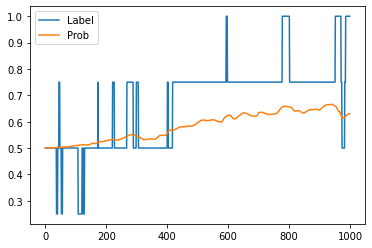

In [7]:
plt.plot(list(range(epochs)), history_hmc['label_acc'], label = 'Label')
plt.plot(list(range(epochs)), history_hmc['prob_acc'], label = 'Prob')
plt.legend()
plt.show()

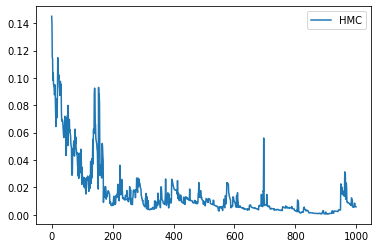

In [8]:
plt.plot(list(range(epochs)), history_hmc['loss'], label = 'HMC')
plt.legend()
plt.show()

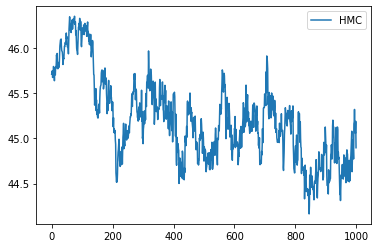

In [9]:
plt.plot(list(range(1000)), tlp_burnin_hmc, label = 'HMC')
plt.legend()
plt.show()

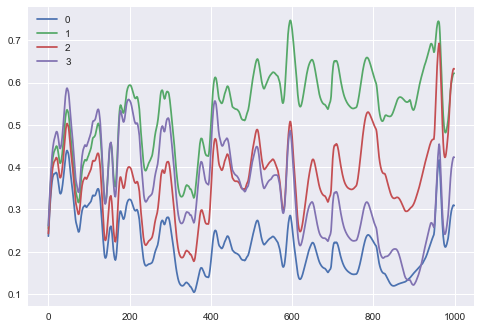

In [12]:
plt.style.use('seaborn')
plt.plot(list(range(epochs)), probs_0, label = '0')
plt.plot(list(range(epochs)), probs_1, label = '1')
plt.plot(list(range(epochs)), probs_2, label = '2')
plt.plot(list(range(epochs)), probs_3, label = '3')
plt.legend()

plt.show()